# Modelling Exploration Notebook
- Latent dirichlet allocation
- Text Classification into fixed categories
- Embed text and build clusers form the embedding space

# Forecasting

## Experiments

In [4]:
# !pip install sqlalchemy

In [6]:
from sqlalchemy import create_engine, Column, Integer, Float, String, ForeignKey, select
# from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [7]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    version = Column('version', Integer)
    target = Column('target', String(100))
    past_rts_col = Column('past_rts_col', String(1000))
    epochs = Column('epochs', Integer)
    prediction_length = Column('prediction_length', Integer)
    num_layers = Column('num_layers', Integer)
    hidden_size = Column('hidden_size', Integer)
    context_length = Column('context_length', Integer)
    weight_decay = Column('weight_decay', Float)
    lr = Column('lr', Float)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_10', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

In [8]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///./config/forecast_config.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

In [18]:
q1 = select(Forecast_Experiment)
q1_result = session.execute(q1) 

for s in q1_result.scalars():
    print(f"""{s.model} (e{s.epochs}, l{s.num_layers}, n{s.hidden_size}, c{s.context_length}, w{s.weight_decay}, r{s.lr}):
        'MAPE': {s.MAPE},
        'avg_wQL': {s.avg_wQL},"""
    )

torch_deepar (e10, l2, n40, c56, w1e-08, r0.001):
        'MAPE': 0.19052389496105562,
        'avg_wQL': 0.15815992665967143,
torch_deepar (e200, l2, n40, c56, w1e-08, r0.001):
        'MAPE': 0.0764770427717032,
        'avg_wQL': 0.06275540445735626,
torch_deepar (e400, l2, n40, c56, w1e-08, r0.001):
        'MAPE': 0.06384816226114393,
        'avg_wQL': 0.05386742979053971,
torch_deepar (e200, l4, n40, c56, w1e-08, r0.001):
        'MAPE': 0.10102059509682562,
        'avg_wQL': 0.08651877718452138,
torch_deepar (e400, l4, n40, c56, w1e-08, r0.001):
        'MAPE': 0.08339516970166147,
        'avg_wQL': 0.072370957789048,
torch_deepar (e1000, l4, n40, c56, w1e-08, r0.001):
        'MAPE': 0.08206782101100342,
        'avg_wQL': 0.07117744262782484,
torch_deepar (e150, l4, n40, c56, w1e-08, r0.001):
        'MAPE': 0.12942370844974463,
        'avg_wQL': 0.11538632056465804,
torch_deepar (e150, l4, n40, c56, w1e-08, r0.001):
        'MAPE': 0.12853513790245066,
        'avg_wQL': 

#### Export/Import Table

In [10]:
# q1 = select(Forecast_Experiment)
# q1_result = session.execute(q1) 

# list_of_experiment = []
# for s in q1_result.scalars():
#     se_temp = {
#         'name':s.model,
#         'target':s.target,
#         'past_rts_col':s.past_rts_col,
#         'epochs':s.epochs,
#         'prediction_length':s.prediction_length,
#         'num_layers':s.num_layers,
#         'hidden_size':s.hidden_size,
#         # 'prediction_length':s.prediction_length,
#         # 'context_length':s.context_length,
#         # 'weight_decay':s.weight_decay,
#         'MASE':s.MASE,
#         'MAPE':s.MAPE,
#         'RMSE':s.RMSE,
#         'wQL_10':s.wQL_10,
#         'wQL_50':s.wQL_50,
#         'wQL_90':s.wQL_90,
#         'avg_wQL':s.avg_wQL,
#     }
#     list_of_experiment.append(se_temp)
# import json

# with open('data.json', 'w') as fp:
#     json.dump(list_of_experiment, fp)

In [11]:
# for e in list_of_experiment:
#     experiment_config = Forecast_Experiment(
#         model = e['name'],
#         version = 1,
#         target = e['target'],
#         past_rts_col = e['past_rts_col'],
#         epochs = e['epochs'],
#         prediction_length = e['prediction_length'],
#         num_layers = e['num_layers'],
#         hidden_size = e['hidden_size'],
#         context_length = 56,
#         lr = 1e-3,
#         weight_decay = 1e-8,
#         MASE = e['MASE'],
#         MAPE = e['MAPE'],
#         RMSE = e['RMSE'],
#         wQL_10 = e['wQL_10'],
#         wQL_50 = e['wQL_50'],
#         wQL_90 = e['wQL_90'],
#         avg_wQL = e['avg_wQL']
#     )
#     session.add(experiment_config)
#     session.commit()

#### model encoding
The model name follows this naming convention: {framework}_{model_name}_{version}. Framework specifies the Machine Learning Framework used to implement the model (mxnet, torch, tensorflow), model_name specifies the Algorithm used (e.g. DeepAR) and the version specifies the stage of experiments as defined below:

- No version: first exploration
    - "../data_engineering/financial_ts/indices.csv",
    - "../data_engineering/financial_ts/ww_gdp.csv",
    - "../data_engineering/timeseries_data/ts_dgelt_events.csv"
    

## DeepAR Modelling

In [12]:
# !pip install "gluonts[torch]"

In [13]:
# import deepar experiment method
from src.deepar_script import run_deepar_experiment
import matplotlib.pyplot as plt
import json
from datetime import timedelta

/opt/conda/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [19]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']

# Estimator specs
version = 1
prediction_length=56
num_layers=4
hidden_size=60
context_length = 200 # implement in script
weight_decay = 1e-4
lr = 1e-1

# Trainer specs
accelerator = "gpu"
devices = -1
max_epochs = 800

In [20]:
forecasts, tss, agg_metrics = run_deepar_experiment(
    input_paths=input_paths,
    target_col=target_col,
    past_rts_col=past_rts_col,
    prediction_length=prediction_length,
    num_layers=num_layers,
    hidden_size=hidden_size,
    weight_decay=weight_decay,
    context_length = context_length,
    lr = lr,
    trainer_kwargs={
        "max_epochs": max_epochs, 
        "accelerator":accelerator, 
        "devices":devices,
    },
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 108 K  | ?        | [1, 100, 56]
----------------------------------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.435     Total estimated model params size (MB)


Epoch 0: : 50it [00:08,  6.18it/s, v_num=39, train_loss=0.883]

Epoch 0, global step 50: 'train_loss' reached 0.88319 (best 0.88319), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:07,  6.81it/s, v_num=39, train_loss=0.794]

Epoch 1, global step 100: 'train_loss' reached 0.79419 (best 0.79419), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.802]

Epoch 2, global step 150: 'train_loss' was not in top 1


Epoch 3: : 50it [00:07,  6.68it/s, v_num=39, train_loss=1.100]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: : 50it [00:07,  6.72it/s, v_num=39, train_loss=1.230]

Epoch 4, global step 250: 'train_loss' was not in top 1


Epoch 5: : 50it [00:07,  6.54it/s, v_num=39, train_loss=1.110]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: : 50it [00:07,  6.48it/s, v_num=39, train_loss=1.110]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: : 50it [00:07,  6.52it/s, v_num=39, train_loss=1.140]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.846]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.954]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.986]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: : 50it [00:07,  6.52it/s, v_num=39, train_loss=1.080]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: : 50it [00:09,  5.42it/s, v_num=39, train_loss=1.070]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: : 50it [00:07,  6.87it/s, v_num=39, train_loss=0.986]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: : 50it [00:07,  6.44it/s, v_num=39, train_loss=1.040]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: : 50it [00:07,  6.89it/s, v_num=39, train_loss=1.090]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.913]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.897]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.899]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: : 50it [00:07,  6.40it/s, v_num=39, train_loss=1.060]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.993]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.951]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.973]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.901]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.933]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.763]

Epoch 25, global step 1300: 'train_loss' reached 0.76318 (best 0.76318), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.750]

Epoch 26, global step 1350: 'train_loss' reached 0.74987 (best 0.74987), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.724]

Epoch 27, global step 1400: 'train_loss' reached 0.72395 (best 0.72395), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.766]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.740]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.774]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.703]

Epoch 31, global step 1600: 'train_loss' reached 0.70305 (best 0.70305), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.767]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.736]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.783]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: : 50it [00:07,  6.84it/s, v_num=39, train_loss=0.793]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.724]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: : 50it [00:07,  6.82it/s, v_num=39, train_loss=0.776]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.817]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.780]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: : 50it [00:07,  6.98it/s, v_num=39, train_loss=0.714]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.790]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.789]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: : 50it [00:07,  6.70it/s, v_num=39, train_loss=0.707]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: : 50it [00:07,  6.70it/s, v_num=39, train_loss=0.722]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: : 50it [00:07,  6.77it/s, v_num=39, train_loss=0.722]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.650]

Epoch 46, global step 2350: 'train_loss' reached 0.65015 (best 0.65015), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.660]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.681]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.736]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.736]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.771]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: : 50it [00:07,  6.87it/s, v_num=39, train_loss=0.699]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.697]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.669]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: : 50it [00:07,  6.70it/s, v_num=39, train_loss=0.864]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.637]

Epoch 56, global step 2850: 'train_loss' reached 0.63734 (best 0.63734), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=56-step=2850.ckpt' as top 1


Epoch 57: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.716]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.654]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.697]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.690]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.669]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.727]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.681]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.664]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.754]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.697]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: : 50it [00:07,  6.27it/s, v_num=39, train_loss=0.684]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.674]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: : 50it [00:07,  6.82it/s, v_num=39, train_loss=0.703]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.800]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: : 50it [00:07,  6.26it/s, v_num=39, train_loss=0.773]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: : 50it [00:07,  6.87it/s, v_num=39, train_loss=0.639]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.681]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.705]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.658]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.708]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: : 50it [00:07,  6.28it/s, v_num=39, train_loss=0.667]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.686]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.695]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: : 50it [00:07,  7.02it/s, v_num=39, train_loss=0.697]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.662]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.616]

Epoch 82, global step 4150: 'train_loss' reached 0.61583 (best 0.61583), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=82-step=4150.ckpt' as top 1


Epoch 83: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.691]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.662]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: : 50it [00:07,  6.76it/s, v_num=39, train_loss=0.649]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: : 50it [00:07,  6.78it/s, v_num=39, train_loss=0.744]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: : 50it [00:07,  6.25it/s, v_num=39, train_loss=0.644]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.567]

Epoch 88, global step 4450: 'train_loss' reached 0.56676 (best 0.56676), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=88-step=4450.ckpt' as top 1


Epoch 89: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.637]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.674]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.638]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.667]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.744]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.658]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.694]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.564]

Epoch 96, global step 4850: 'train_loss' reached 0.56352 (best 0.56352), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=96-step=4850.ckpt' as top 1


Epoch 97: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.628]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.660]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: : 50it [00:07,  6.91it/s, v_num=39, train_loss=0.701]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 100: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.685]

Epoch 100, global step 5050: 'train_loss' was not in top 1


Epoch 101: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.582]

Epoch 101, global step 5100: 'train_loss' was not in top 1


Epoch 102: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.586]

Epoch 102, global step 5150: 'train_loss' was not in top 1


Epoch 103: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.615]

Epoch 103, global step 5200: 'train_loss' was not in top 1


Epoch 104: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.665]

Epoch 104, global step 5250: 'train_loss' was not in top 1


Epoch 105: : 50it [00:07,  6.26it/s, v_num=39, train_loss=0.630]

Epoch 105, global step 5300: 'train_loss' was not in top 1


Epoch 106: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.602]

Epoch 106, global step 5350: 'train_loss' was not in top 1


Epoch 107: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.550]

Epoch 107, global step 5400: 'train_loss' reached 0.54975 (best 0.54975), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=107-step=5400.ckpt' as top 1


Epoch 108: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.604]

Epoch 108, global step 5450: 'train_loss' was not in top 1


Epoch 109: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.640]

Epoch 109, global step 5500: 'train_loss' was not in top 1


Epoch 110: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.632]

Epoch 110, global step 5550: 'train_loss' was not in top 1


Epoch 111: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.629]

Epoch 111, global step 5600: 'train_loss' was not in top 1


Epoch 112: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.606]

Epoch 112, global step 5650: 'train_loss' was not in top 1


Epoch 113: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.573]

Epoch 113, global step 5700: 'train_loss' was not in top 1


Epoch 114: : 50it [00:07,  6.69it/s, v_num=39, train_loss=0.639]

Epoch 114, global step 5750: 'train_loss' was not in top 1


Epoch 115: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.546]

Epoch 115, global step 5800: 'train_loss' reached 0.54610 (best 0.54610), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=115-step=5800.ckpt' as top 1


Epoch 116: : 50it [00:07,  6.84it/s, v_num=39, train_loss=0.649]

Epoch 116, global step 5850: 'train_loss' was not in top 1


Epoch 117: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.576]

Epoch 117, global step 5900: 'train_loss' was not in top 1


Epoch 118: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.568]

Epoch 118, global step 5950: 'train_loss' was not in top 1


Epoch 119: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.629]

Epoch 119, global step 6000: 'train_loss' was not in top 1


Epoch 120: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.652]

Epoch 120, global step 6050: 'train_loss' was not in top 1


Epoch 121: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.596]

Epoch 121, global step 6100: 'train_loss' was not in top 1


Epoch 122: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.578]

Epoch 122, global step 6150: 'train_loss' was not in top 1


Epoch 123: : 50it [00:07,  6.77it/s, v_num=39, train_loss=0.571]

Epoch 123, global step 6200: 'train_loss' was not in top 1


Epoch 124: : 50it [00:07,  6.69it/s, v_num=39, train_loss=0.637]

Epoch 124, global step 6250: 'train_loss' was not in top 1


Epoch 125: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.552]

Epoch 125, global step 6300: 'train_loss' was not in top 1


Epoch 126: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.572]

Epoch 126, global step 6350: 'train_loss' was not in top 1


Epoch 127: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.543]

Epoch 127, global step 6400: 'train_loss' reached 0.54269 (best 0.54269), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=127-step=6400.ckpt' as top 1


Epoch 128: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.612]

Epoch 128, global step 6450: 'train_loss' was not in top 1


Epoch 129: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.588]

Epoch 129, global step 6500: 'train_loss' was not in top 1


Epoch 130: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.584]

Epoch 130, global step 6550: 'train_loss' was not in top 1


Epoch 131: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.489]

Epoch 131, global step 6600: 'train_loss' reached 0.48869 (best 0.48869), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=131-step=6600.ckpt' as top 1


Epoch 132: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.608]

Epoch 132, global step 6650: 'train_loss' was not in top 1


Epoch 133: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.560]

Epoch 133, global step 6700: 'train_loss' was not in top 1


Epoch 134: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.567]

Epoch 134, global step 6750: 'train_loss' was not in top 1


Epoch 135: : 50it [00:07,  6.69it/s, v_num=39, train_loss=0.572]

Epoch 135, global step 6800: 'train_loss' was not in top 1


Epoch 136: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.547]

Epoch 136, global step 6850: 'train_loss' was not in top 1


Epoch 137: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.471]

Epoch 137, global step 6900: 'train_loss' reached 0.47134 (best 0.47134), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=137-step=6900.ckpt' as top 1


Epoch 138: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.554]

Epoch 138, global step 6950: 'train_loss' was not in top 1


Epoch 139: : 50it [00:07,  6.86it/s, v_num=39, train_loss=0.548]

Epoch 139, global step 7000: 'train_loss' was not in top 1


Epoch 140: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.561]

Epoch 140, global step 7050: 'train_loss' was not in top 1


Epoch 141: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.550]

Epoch 141, global step 7100: 'train_loss' was not in top 1


Epoch 142: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.499]

Epoch 142, global step 7150: 'train_loss' was not in top 1


Epoch 143: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.498]

Epoch 143, global step 7200: 'train_loss' was not in top 1


Epoch 144: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.530]

Epoch 144, global step 7250: 'train_loss' was not in top 1


Epoch 145: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.559]

Epoch 145, global step 7300: 'train_loss' was not in top 1


Epoch 146: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.477]

Epoch 146, global step 7350: 'train_loss' was not in top 1


Epoch 147: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.526]

Epoch 147, global step 7400: 'train_loss' was not in top 1


Epoch 148: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.493]

Epoch 148, global step 7450: 'train_loss' was not in top 1


Epoch 149: : 50it [00:07,  6.69it/s, v_num=39, train_loss=0.546]

Epoch 149, global step 7500: 'train_loss' was not in top 1


Epoch 150: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.509]

Epoch 150, global step 7550: 'train_loss' was not in top 1


Epoch 151: : 50it [00:07,  6.27it/s, v_num=39, train_loss=0.498]

Epoch 151, global step 7600: 'train_loss' was not in top 1


Epoch 152: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.498]

Epoch 152, global step 7650: 'train_loss' was not in top 1


Epoch 153: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.494]

Epoch 153, global step 7700: 'train_loss' was not in top 1


Epoch 154: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.517]

Epoch 154, global step 7750: 'train_loss' was not in top 1


Epoch 155: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.462]

Epoch 155, global step 7800: 'train_loss' reached 0.46178 (best 0.46178), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=155-step=7800.ckpt' as top 1


Epoch 156: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.543]

Epoch 156, global step 7850: 'train_loss' was not in top 1


Epoch 157: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.479]

Epoch 157, global step 7900: 'train_loss' was not in top 1


Epoch 158: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.503]

Epoch 158, global step 7950: 'train_loss' was not in top 1


Epoch 159: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.541]

Epoch 159, global step 8000: 'train_loss' was not in top 1


Epoch 160: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.510]

Epoch 160, global step 8050: 'train_loss' was not in top 1


Epoch 161: : 50it [00:07,  6.31it/s, v_num=39, train_loss=0.530]

Epoch 161, global step 8100: 'train_loss' was not in top 1


Epoch 162: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.501]

Epoch 162, global step 8150: 'train_loss' was not in top 1


Epoch 163: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.464]

Epoch 163, global step 8200: 'train_loss' was not in top 1


Epoch 164: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.539]

Epoch 164, global step 8250: 'train_loss' was not in top 1


Epoch 165: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.508]

Epoch 165, global step 8300: 'train_loss' was not in top 1


Epoch 166: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.493]

Epoch 166, global step 8350: 'train_loss' was not in top 1


Epoch 167: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.456]

Epoch 167, global step 8400: 'train_loss' reached 0.45581 (best 0.45581), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=167-step=8400.ckpt' as top 1


Epoch 168: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.498]

Epoch 168, global step 8450: 'train_loss' was not in top 1


Epoch 169: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.476]

Epoch 169, global step 8500: 'train_loss' was not in top 1


Epoch 170: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.480]

Epoch 170, global step 8550: 'train_loss' was not in top 1


Epoch 171: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.507]

Epoch 171, global step 8600: 'train_loss' was not in top 1


Epoch 172: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.504]

Epoch 172, global step 8650: 'train_loss' was not in top 1


Epoch 173: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.513]

Epoch 173, global step 8700: 'train_loss' was not in top 1


Epoch 174: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.470]

Epoch 174, global step 8750: 'train_loss' was not in top 1


Epoch 175: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.507]

Epoch 175, global step 8800: 'train_loss' was not in top 1


Epoch 176: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.465]

Epoch 176, global step 8850: 'train_loss' was not in top 1


Epoch 177: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.473]

Epoch 177, global step 8900: 'train_loss' was not in top 1


Epoch 178: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.503]

Epoch 178, global step 8950: 'train_loss' was not in top 1


Epoch 179: : 50it [00:07,  6.77it/s, v_num=39, train_loss=0.498]

Epoch 179, global step 9000: 'train_loss' was not in top 1


Epoch 180: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.432]

Epoch 180, global step 9050: 'train_loss' reached 0.43200 (best 0.43200), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=180-step=9050.ckpt' as top 1


Epoch 181: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.518]

Epoch 181, global step 9100: 'train_loss' was not in top 1


Epoch 182: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.485]

Epoch 182, global step 9150: 'train_loss' was not in top 1


Epoch 183: : 50it [00:07,  6.76it/s, v_num=39, train_loss=0.497]

Epoch 183, global step 9200: 'train_loss' was not in top 1


Epoch 184: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.490]

Epoch 184, global step 9250: 'train_loss' was not in top 1


Epoch 185: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.499]

Epoch 185, global step 9300: 'train_loss' was not in top 1


Epoch 186: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.513]

Epoch 186, global step 9350: 'train_loss' was not in top 1


Epoch 187: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.440]

Epoch 187, global step 9400: 'train_loss' was not in top 1


Epoch 188: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.429]

Epoch 188, global step 9450: 'train_loss' reached 0.42936 (best 0.42936), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=188-step=9450.ckpt' as top 1


Epoch 189: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.507]

Epoch 189, global step 9500: 'train_loss' was not in top 1


Epoch 190: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.518]

Epoch 190, global step 9550: 'train_loss' was not in top 1


Epoch 191: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.529]

Epoch 191, global step 9600: 'train_loss' was not in top 1


Epoch 192: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.393]

Epoch 192, global step 9650: 'train_loss' reached 0.39348 (best 0.39348), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=192-step=9650.ckpt' as top 1


Epoch 193: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.498]

Epoch 193, global step 9700: 'train_loss' was not in top 1


Epoch 194: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.498]

Epoch 194, global step 9750: 'train_loss' was not in top 1


Epoch 195: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.476]

Epoch 195, global step 9800: 'train_loss' was not in top 1


Epoch 196: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.483]

Epoch 196, global step 9850: 'train_loss' was not in top 1


Epoch 197: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.499]

Epoch 197, global step 9900: 'train_loss' was not in top 1


Epoch 198: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.436]

Epoch 198, global step 9950: 'train_loss' was not in top 1


Epoch 199: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.473]

Epoch 199, global step 10000: 'train_loss' was not in top 1


Epoch 200: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.525]

Epoch 200, global step 10050: 'train_loss' was not in top 1


Epoch 201: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.498]

Epoch 201, global step 10100: 'train_loss' was not in top 1


Epoch 202: : 50it [00:07,  6.90it/s, v_num=39, train_loss=0.526]

Epoch 202, global step 10150: 'train_loss' was not in top 1


Epoch 203: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.484]

Epoch 203, global step 10200: 'train_loss' was not in top 1


Epoch 204: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.471]

Epoch 204, global step 10250: 'train_loss' was not in top 1


Epoch 205: : 50it [00:07,  6.81it/s, v_num=39, train_loss=0.538]

Epoch 205, global step 10300: 'train_loss' was not in top 1


Epoch 206: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.485]

Epoch 206, global step 10350: 'train_loss' was not in top 1


Epoch 207: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.472]

Epoch 207, global step 10400: 'train_loss' was not in top 1


Epoch 208: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.426]

Epoch 208, global step 10450: 'train_loss' was not in top 1


Epoch 209: : 50it [00:07,  6.30it/s, v_num=39, train_loss=0.456]

Epoch 209, global step 10500: 'train_loss' was not in top 1


Epoch 210: : 50it [00:07,  6.84it/s, v_num=39, train_loss=0.461]

Epoch 210, global step 10550: 'train_loss' was not in top 1


Epoch 211: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.531]

Epoch 211, global step 10600: 'train_loss' was not in top 1


Epoch 212: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.509]

Epoch 212, global step 10650: 'train_loss' was not in top 1


Epoch 213: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.507]

Epoch 213, global step 10700: 'train_loss' was not in top 1


Epoch 214: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.488]

Epoch 214, global step 10750: 'train_loss' was not in top 1


Epoch 215: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.484]

Epoch 215, global step 10800: 'train_loss' was not in top 1


Epoch 216: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.517]

Epoch 216, global step 10850: 'train_loss' was not in top 1


Epoch 217: : 50it [00:07,  6.76it/s, v_num=39, train_loss=0.524]

Epoch 217, global step 10900: 'train_loss' was not in top 1


Epoch 218: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.461]

Epoch 218, global step 10950: 'train_loss' was not in top 1


Epoch 219: : 50it [00:07,  6.78it/s, v_num=39, train_loss=0.434]

Epoch 219, global step 11000: 'train_loss' was not in top 1


Epoch 220: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.455]

Epoch 220, global step 11050: 'train_loss' was not in top 1


Epoch 221: : 50it [00:07,  6.82it/s, v_num=39, train_loss=0.449]

Epoch 221, global step 11100: 'train_loss' was not in top 1


Epoch 222: : 50it [00:07,  6.30it/s, v_num=39, train_loss=0.472]

Epoch 222, global step 11150: 'train_loss' was not in top 1


Epoch 223: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.466]

Epoch 223, global step 11200: 'train_loss' was not in top 1


Epoch 224: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.490]

Epoch 224, global step 11250: 'train_loss' was not in top 1


Epoch 225: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.532]

Epoch 225, global step 11300: 'train_loss' was not in top 1


Epoch 226: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.405]

Epoch 226, global step 11350: 'train_loss' was not in top 1


Epoch 227: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.499]

Epoch 227, global step 11400: 'train_loss' was not in top 1


Epoch 228: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.466]

Epoch 228, global step 11450: 'train_loss' was not in top 1


Epoch 229: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.451]

Epoch 229, global step 11500: 'train_loss' was not in top 1


Epoch 230: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.449]

Epoch 230, global step 11550: 'train_loss' was not in top 1


Epoch 231: : 50it [00:07,  6.87it/s, v_num=39, train_loss=0.476]

Epoch 231, global step 11600: 'train_loss' was not in top 1


Epoch 232: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.463]

Epoch 232, global step 11650: 'train_loss' was not in top 1


Epoch 233: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.458]

Epoch 233, global step 11700: 'train_loss' was not in top 1


Epoch 234: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.467]

Epoch 234, global step 11750: 'train_loss' was not in top 1


Epoch 235: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.474]

Epoch 235, global step 11800: 'train_loss' was not in top 1


Epoch 236: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.420]

Epoch 236, global step 11850: 'train_loss' was not in top 1


Epoch 237: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.484]

Epoch 237, global step 11900: 'train_loss' was not in top 1


Epoch 238: : 50it [00:07,  6.90it/s, v_num=39, train_loss=0.473]

Epoch 238, global step 11950: 'train_loss' was not in top 1


Epoch 239: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.481]

Epoch 239, global step 12000: 'train_loss' was not in top 1


Epoch 240: : 50it [00:07,  6.70it/s, v_num=39, train_loss=0.469]

Epoch 240, global step 12050: 'train_loss' was not in top 1


Epoch 241: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.482]

Epoch 241, global step 12100: 'train_loss' was not in top 1


Epoch 242: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.533]

Epoch 242, global step 12150: 'train_loss' was not in top 1


Epoch 243: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.480]

Epoch 243, global step 12200: 'train_loss' was not in top 1


Epoch 244: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.454]

Epoch 244, global step 12250: 'train_loss' was not in top 1


Epoch 245: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.487]

Epoch 245, global step 12300: 'train_loss' was not in top 1


Epoch 246: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.459]

Epoch 246, global step 12350: 'train_loss' was not in top 1


Epoch 247: : 50it [00:07,  6.79it/s, v_num=39, train_loss=0.485]

Epoch 247, global step 12400: 'train_loss' was not in top 1


Epoch 248: : 50it [00:07,  6.31it/s, v_num=39, train_loss=0.433]

Epoch 248, global step 12450: 'train_loss' was not in top 1


Epoch 249: : 50it [00:07,  6.96it/s, v_num=39, train_loss=0.488]

Epoch 249, global step 12500: 'train_loss' was not in top 1


Epoch 250: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.493]

Epoch 250, global step 12550: 'train_loss' was not in top 1


Epoch 251: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.462]

Epoch 251, global step 12600: 'train_loss' was not in top 1


Epoch 252: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.525]

Epoch 252, global step 12650: 'train_loss' was not in top 1


Epoch 253: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.450]

Epoch 253, global step 12700: 'train_loss' was not in top 1


Epoch 254: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.445]

Epoch 254, global step 12750: 'train_loss' was not in top 1


Epoch 255: : 50it [00:07,  6.78it/s, v_num=39, train_loss=0.431]

Epoch 255, global step 12800: 'train_loss' was not in top 1


Epoch 256: : 50it [00:07,  6.81it/s, v_num=39, train_loss=0.477]

Epoch 256, global step 12850: 'train_loss' was not in top 1


Epoch 257: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.396]

Epoch 257, global step 12900: 'train_loss' was not in top 1


Epoch 258: : 50it [00:07,  6.78it/s, v_num=39, train_loss=0.453]

Epoch 258, global step 12950: 'train_loss' was not in top 1


Epoch 259: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.475]

Epoch 259, global step 13000: 'train_loss' was not in top 1


Epoch 260: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.455]

Epoch 260, global step 13050: 'train_loss' was not in top 1


Epoch 261: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.439]

Epoch 261, global step 13100: 'train_loss' was not in top 1


Epoch 262: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.439]

Epoch 262, global step 13150: 'train_loss' was not in top 1


Epoch 263: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.474]

Epoch 263, global step 13200: 'train_loss' was not in top 1


Epoch 264: : 50it [00:07,  6.31it/s, v_num=39, train_loss=0.478]

Epoch 264, global step 13250: 'train_loss' was not in top 1


Epoch 265: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.457]

Epoch 265, global step 13300: 'train_loss' was not in top 1


Epoch 266: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.486]

Epoch 266, global step 13350: 'train_loss' was not in top 1


Epoch 267: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.479]

Epoch 267, global step 13400: 'train_loss' was not in top 1


Epoch 268: : 50it [00:07,  6.77it/s, v_num=39, train_loss=0.476]

Epoch 268, global step 13450: 'train_loss' was not in top 1


Epoch 269: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.463]

Epoch 269, global step 13500: 'train_loss' was not in top 1


Epoch 270: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.521]

Epoch 270, global step 13550: 'train_loss' was not in top 1


Epoch 271: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.538]

Epoch 271, global step 13600: 'train_loss' was not in top 1


Epoch 272: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.478]

Epoch 272, global step 13650: 'train_loss' was not in top 1


Epoch 273: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.461]

Epoch 273, global step 13700: 'train_loss' was not in top 1


Epoch 274: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.531]

Epoch 274, global step 13750: 'train_loss' was not in top 1


Epoch 275: : 50it [00:07,  6.78it/s, v_num=39, train_loss=0.507]

Epoch 275, global step 13800: 'train_loss' was not in top 1


Epoch 276: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.515]

Epoch 276, global step 13850: 'train_loss' was not in top 1


Epoch 277: : 50it [00:07,  6.77it/s, v_num=39, train_loss=0.453]

Epoch 277, global step 13900: 'train_loss' was not in top 1


Epoch 278: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.472]

Epoch 278, global step 13950: 'train_loss' was not in top 1


Epoch 279: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.466]

Epoch 279, global step 14000: 'train_loss' was not in top 1


Epoch 280: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.435]

Epoch 280, global step 14050: 'train_loss' was not in top 1


Epoch 281: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.471]

Epoch 281, global step 14100: 'train_loss' was not in top 1


Epoch 282: : 50it [00:07,  6.31it/s, v_num=39, train_loss=0.493]

Epoch 282, global step 14150: 'train_loss' was not in top 1


Epoch 283: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.490]

Epoch 283, global step 14200: 'train_loss' was not in top 1


Epoch 284: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.483]

Epoch 284, global step 14250: 'train_loss' was not in top 1


Epoch 285: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.426]

Epoch 285, global step 14300: 'train_loss' was not in top 1


Epoch 286: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.469]

Epoch 286, global step 14350: 'train_loss' was not in top 1


Epoch 287: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.461]

Epoch 287, global step 14400: 'train_loss' was not in top 1


Epoch 288: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.462]

Epoch 288, global step 14450: 'train_loss' was not in top 1


Epoch 289: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.503]

Epoch 289, global step 14500: 'train_loss' was not in top 1


Epoch 290: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.452]

Epoch 290, global step 14550: 'train_loss' was not in top 1


Epoch 291: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.489]

Epoch 291, global step 14600: 'train_loss' was not in top 1


Epoch 292: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.452]

Epoch 292, global step 14650: 'train_loss' was not in top 1


Epoch 293: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.485]

Epoch 293, global step 14700: 'train_loss' was not in top 1


Epoch 294: : 50it [00:07,  6.28it/s, v_num=39, train_loss=0.490]

Epoch 294, global step 14750: 'train_loss' was not in top 1


Epoch 295: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.443]

Epoch 295, global step 14800: 'train_loss' was not in top 1


Epoch 296: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.456]

Epoch 296, global step 14850: 'train_loss' was not in top 1


Epoch 297: : 50it [00:07,  6.28it/s, v_num=39, train_loss=0.474]

Epoch 297, global step 14900: 'train_loss' was not in top 1


Epoch 298: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.474]

Epoch 298, global step 14950: 'train_loss' was not in top 1


Epoch 299: : 50it [00:07,  6.69it/s, v_num=39, train_loss=0.510]

Epoch 299, global step 15000: 'train_loss' was not in top 1


Epoch 300: : 50it [00:07,  6.76it/s, v_num=39, train_loss=0.488]

Epoch 300, global step 15050: 'train_loss' was not in top 1


Epoch 301: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.446]

Epoch 301, global step 15100: 'train_loss' was not in top 1


Epoch 302: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.437]

Epoch 302, global step 15150: 'train_loss' was not in top 1


Epoch 303: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.481]

Epoch 303, global step 15200: 'train_loss' was not in top 1


Epoch 304: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.473]

Epoch 304, global step 15250: 'train_loss' was not in top 1


Epoch 305: : 50it [00:07,  6.79it/s, v_num=39, train_loss=0.481]

Epoch 305, global step 15300: 'train_loss' was not in top 1


Epoch 306: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.525]

Epoch 306, global step 15350: 'train_loss' was not in top 1


Epoch 307: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.493]

Epoch 307, global step 15400: 'train_loss' was not in top 1


Epoch 308: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.460]

Epoch 308, global step 15450: 'train_loss' was not in top 1


Epoch 309: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.448]

Epoch 309, global step 15500: 'train_loss' was not in top 1


Epoch 310: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.467]

Epoch 310, global step 15550: 'train_loss' was not in top 1


Epoch 311: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.450]

Epoch 311, global step 15600: 'train_loss' was not in top 1


Epoch 312: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.492]

Epoch 312, global step 15650: 'train_loss' was not in top 1


Epoch 313: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.405]

Epoch 313, global step 15700: 'train_loss' was not in top 1


Epoch 314: : 50it [00:07,  6.30it/s, v_num=39, train_loss=0.428]

Epoch 314, global step 15750: 'train_loss' was not in top 1


Epoch 315: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.514]

Epoch 315, global step 15800: 'train_loss' was not in top 1


Epoch 316: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.469]

Epoch 316, global step 15850: 'train_loss' was not in top 1


Epoch 317: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.478]

Epoch 317, global step 15900: 'train_loss' was not in top 1


Epoch 318: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.448]

Epoch 318, global step 15950: 'train_loss' was not in top 1


Epoch 319: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.465]

Epoch 319, global step 16000: 'train_loss' was not in top 1


Epoch 320: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.464]

Epoch 320, global step 16050: 'train_loss' was not in top 1


Epoch 321: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.495]

Epoch 321, global step 16100: 'train_loss' was not in top 1


Epoch 322: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.486]

Epoch 322, global step 16150: 'train_loss' was not in top 1


Epoch 323: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.478]

Epoch 323, global step 16200: 'train_loss' was not in top 1


Epoch 324: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.447]

Epoch 324, global step 16250: 'train_loss' was not in top 1


Epoch 325: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.504]

Epoch 325, global step 16300: 'train_loss' was not in top 1


Epoch 326: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.467]

Epoch 326, global step 16350: 'train_loss' was not in top 1


Epoch 327: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.467]

Epoch 327, global step 16400: 'train_loss' was not in top 1


Epoch 328: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.502]

Epoch 328, global step 16450: 'train_loss' was not in top 1


Epoch 329: : 50it [00:07,  6.94it/s, v_num=39, train_loss=0.533]

Epoch 329, global step 16500: 'train_loss' was not in top 1


Epoch 330: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.466]

Epoch 330, global step 16550: 'train_loss' was not in top 1


Epoch 331: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.427]

Epoch 331, global step 16600: 'train_loss' was not in top 1


Epoch 332: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.492]

Epoch 332, global step 16650: 'train_loss' was not in top 1


Epoch 333: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.503]

Epoch 333, global step 16700: 'train_loss' was not in top 1


Epoch 334: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.453]

Epoch 334, global step 16750: 'train_loss' was not in top 1


Epoch 335: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.455]

Epoch 335, global step 16800: 'train_loss' was not in top 1


Epoch 336: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.449]

Epoch 336, global step 16850: 'train_loss' was not in top 1


Epoch 337: : 50it [00:07,  6.27it/s, v_num=39, train_loss=0.425]

Epoch 337, global step 16900: 'train_loss' was not in top 1


Epoch 338: : 50it [00:08,  6.20it/s, v_num=39, train_loss=0.484]

Epoch 338, global step 16950: 'train_loss' was not in top 1


Epoch 339: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.476]

Epoch 339, global step 17000: 'train_loss' was not in top 1


Epoch 340: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.506]

Epoch 340, global step 17050: 'train_loss' was not in top 1


Epoch 341: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.476]

Epoch 341, global step 17100: 'train_loss' was not in top 1


Epoch 342: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.479]

Epoch 342, global step 17150: 'train_loss' was not in top 1


Epoch 343: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.517]

Epoch 343, global step 17200: 'train_loss' was not in top 1


Epoch 344: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.487]

Epoch 344, global step 17250: 'train_loss' was not in top 1


Epoch 345: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.477]

Epoch 345, global step 17300: 'train_loss' was not in top 1


Epoch 346: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.448]

Epoch 346, global step 17350: 'train_loss' was not in top 1


Epoch 347: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.483]

Epoch 347, global step 17400: 'train_loss' was not in top 1


Epoch 348: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.493]

Epoch 348, global step 17450: 'train_loss' was not in top 1


Epoch 349: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.463]

Epoch 349, global step 17500: 'train_loss' was not in top 1


Epoch 350: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.456]

Epoch 350, global step 17550: 'train_loss' was not in top 1


Epoch 351: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.452]

Epoch 351, global step 17600: 'train_loss' was not in top 1


Epoch 352: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.507]

Epoch 352, global step 17650: 'train_loss' was not in top 1


Epoch 353: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.485]

Epoch 353, global step 17700: 'train_loss' was not in top 1


Epoch 354: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.459]

Epoch 354, global step 17750: 'train_loss' was not in top 1


Epoch 355: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.429]

Epoch 355, global step 17800: 'train_loss' was not in top 1


Epoch 356: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.467]

Epoch 356, global step 17850: 'train_loss' was not in top 1


Epoch 357: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.474]

Epoch 357, global step 17900: 'train_loss' was not in top 1


Epoch 358: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.438]

Epoch 358, global step 17950: 'train_loss' was not in top 1


Epoch 359: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.477]

Epoch 359, global step 18000: 'train_loss' was not in top 1


Epoch 360: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.507]

Epoch 360, global step 18050: 'train_loss' was not in top 1


Epoch 361: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.457]

Epoch 361, global step 18100: 'train_loss' was not in top 1


Epoch 362: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.476]

Epoch 362, global step 18150: 'train_loss' was not in top 1


Epoch 363: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.474]

Epoch 363, global step 18200: 'train_loss' was not in top 1


Epoch 364: : 50it [00:07,  6.70it/s, v_num=39, train_loss=0.481]

Epoch 364, global step 18250: 'train_loss' was not in top 1


Epoch 365: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.491]

Epoch 365, global step 18300: 'train_loss' was not in top 1


Epoch 366: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.476]

Epoch 366, global step 18350: 'train_loss' was not in top 1


Epoch 367: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.500]

Epoch 367, global step 18400: 'train_loss' was not in top 1


Epoch 368: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.473]

Epoch 368, global step 18450: 'train_loss' was not in top 1


Epoch 369: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.446]

Epoch 369, global step 18500: 'train_loss' was not in top 1


Epoch 370: : 50it [00:08,  6.17it/s, v_num=39, train_loss=0.493]

Epoch 370, global step 18550: 'train_loss' was not in top 1


Epoch 371: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.447]

Epoch 371, global step 18600: 'train_loss' was not in top 1


Epoch 372: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.416]

Epoch 372, global step 18650: 'train_loss' was not in top 1


Epoch 373: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.475]

Epoch 373, global step 18700: 'train_loss' was not in top 1


Epoch 374: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.490]

Epoch 374, global step 18750: 'train_loss' was not in top 1


Epoch 375: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.503]

Epoch 375, global step 18800: 'train_loss' was not in top 1


Epoch 376: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.485]

Epoch 376, global step 18850: 'train_loss' was not in top 1


Epoch 377: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.480]

Epoch 377, global step 18900: 'train_loss' was not in top 1


Epoch 378: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.434]

Epoch 378, global step 18950: 'train_loss' was not in top 1


Epoch 379: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.465]

Epoch 379, global step 19000: 'train_loss' was not in top 1


Epoch 380: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.462]

Epoch 380, global step 19050: 'train_loss' was not in top 1


Epoch 381: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.435]

Epoch 381, global step 19100: 'train_loss' was not in top 1


Epoch 382: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.516]

Epoch 382, global step 19150: 'train_loss' was not in top 1


Epoch 383: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.519]

Epoch 383, global step 19200: 'train_loss' was not in top 1


Epoch 384: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.479]

Epoch 384, global step 19250: 'train_loss' was not in top 1


Epoch 385: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.435]

Epoch 385, global step 19300: 'train_loss' was not in top 1


Epoch 386: : 50it [00:08,  6.25it/s, v_num=39, train_loss=0.481]

Epoch 386, global step 19350: 'train_loss' was not in top 1


Epoch 387: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.463]

Epoch 387, global step 19400: 'train_loss' was not in top 1


Epoch 388: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.439]

Epoch 388, global step 19450: 'train_loss' was not in top 1


Epoch 389: : 50it [00:07,  6.78it/s, v_num=39, train_loss=0.454]

Epoch 389, global step 19500: 'train_loss' was not in top 1


Epoch 390: : 50it [00:08,  6.25it/s, v_num=39, train_loss=0.479]

Epoch 390, global step 19550: 'train_loss' was not in top 1


Epoch 391: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.470]

Epoch 391, global step 19600: 'train_loss' was not in top 1


Epoch 392: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.471]

Epoch 392, global step 19650: 'train_loss' was not in top 1


Epoch 393: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.465]

Epoch 393, global step 19700: 'train_loss' was not in top 1


Epoch 394: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.495]

Epoch 394, global step 19750: 'train_loss' was not in top 1


Epoch 395: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.474]

Epoch 395, global step 19800: 'train_loss' was not in top 1


Epoch 396: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.507]

Epoch 396, global step 19850: 'train_loss' was not in top 1


Epoch 397: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.463]

Epoch 397, global step 19900: 'train_loss' was not in top 1


Epoch 398: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.491]

Epoch 398, global step 19950: 'train_loss' was not in top 1


Epoch 399: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.462]

Epoch 399, global step 20000: 'train_loss' was not in top 1


Epoch 400: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.478]

Epoch 400, global step 20050: 'train_loss' was not in top 1


Epoch 401: : 50it [00:07,  6.87it/s, v_num=39, train_loss=0.497]

Epoch 401, global step 20100: 'train_loss' was not in top 1


Epoch 402: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.451]

Epoch 402, global step 20150: 'train_loss' was not in top 1


Epoch 403: : 50it [00:07,  6.86it/s, v_num=39, train_loss=0.450]

Epoch 403, global step 20200: 'train_loss' was not in top 1


Epoch 404: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.465]

Epoch 404, global step 20250: 'train_loss' was not in top 1


Epoch 405: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.438]

Epoch 405, global step 20300: 'train_loss' was not in top 1


Epoch 406: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.488]

Epoch 406, global step 20350: 'train_loss' was not in top 1


Epoch 407: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.440]

Epoch 407, global step 20400: 'train_loss' was not in top 1


Epoch 408: : 50it [00:08,  6.23it/s, v_num=39, train_loss=0.446]

Epoch 408, global step 20450: 'train_loss' was not in top 1


Epoch 409: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.433]

Epoch 409, global step 20500: 'train_loss' was not in top 1


Epoch 410: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.496]

Epoch 410, global step 20550: 'train_loss' was not in top 1


Epoch 411: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.560]

Epoch 411, global step 20600: 'train_loss' was not in top 1


Epoch 412: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.457]

Epoch 412, global step 20650: 'train_loss' was not in top 1


Epoch 413: : 50it [00:07,  6.77it/s, v_num=39, train_loss=0.456]

Epoch 413, global step 20700: 'train_loss' was not in top 1


Epoch 414: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.481]

Epoch 414, global step 20750: 'train_loss' was not in top 1


Epoch 415: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.510]

Epoch 415, global step 20800: 'train_loss' was not in top 1


Epoch 416: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.426]

Epoch 416, global step 20850: 'train_loss' was not in top 1


Epoch 417: : 50it [00:08,  6.24it/s, v_num=39, train_loss=0.502]

Epoch 417, global step 20900: 'train_loss' was not in top 1


Epoch 418: : 50it [00:08,  6.09it/s, v_num=39, train_loss=0.414]

Epoch 418, global step 20950: 'train_loss' was not in top 1


Epoch 419: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.458]

Epoch 419, global step 21000: 'train_loss' was not in top 1


Epoch 420: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.513]

Epoch 420, global step 21050: 'train_loss' was not in top 1


Epoch 421: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.493]

Epoch 421, global step 21100: 'train_loss' was not in top 1


Epoch 422: : 50it [00:07,  6.76it/s, v_num=39, train_loss=0.498]

Epoch 422, global step 21150: 'train_loss' was not in top 1


Epoch 423: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.498]

Epoch 423, global step 21200: 'train_loss' was not in top 1


Epoch 424: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.504]

Epoch 424, global step 21250: 'train_loss' was not in top 1


Epoch 425: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.409]

Epoch 425, global step 21300: 'train_loss' was not in top 1


Epoch 426: : 50it [00:08,  6.20it/s, v_num=39, train_loss=0.472]

Epoch 426, global step 21350: 'train_loss' was not in top 1


Epoch 427: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.474]

Epoch 427, global step 21400: 'train_loss' was not in top 1


Epoch 428: : 50it [00:07,  6.74it/s, v_num=39, train_loss=0.502]

Epoch 428, global step 21450: 'train_loss' was not in top 1


Epoch 429: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.477]

Epoch 429, global step 21500: 'train_loss' was not in top 1


Epoch 430: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.443]

Epoch 430, global step 21550: 'train_loss' was not in top 1


Epoch 431: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.543]

Epoch 431, global step 21600: 'train_loss' was not in top 1


Epoch 432: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.446]

Epoch 432, global step 21650: 'train_loss' was not in top 1


Epoch 433: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.485]

Epoch 433, global step 21700: 'train_loss' was not in top 1


Epoch 434: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.446]

Epoch 434, global step 21750: 'train_loss' was not in top 1


Epoch 435: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.461]

Epoch 435, global step 21800: 'train_loss' was not in top 1


Epoch 436: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.447]

Epoch 436, global step 21850: 'train_loss' was not in top 1


Epoch 437: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.460]

Epoch 437, global step 21900: 'train_loss' was not in top 1


Epoch 438: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.476]

Epoch 438, global step 21950: 'train_loss' was not in top 1


Epoch 439: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.463]

Epoch 439, global step 22000: 'train_loss' was not in top 1


Epoch 440: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.478]

Epoch 440, global step 22050: 'train_loss' was not in top 1


Epoch 441: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.465]

Epoch 441, global step 22100: 'train_loss' was not in top 1


Epoch 442: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.455]

Epoch 442, global step 22150: 'train_loss' was not in top 1


Epoch 443: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.481]

Epoch 443, global step 22200: 'train_loss' was not in top 1


Epoch 444: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.467]

Epoch 444, global step 22250: 'train_loss' was not in top 1


Epoch 445: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.427]

Epoch 445, global step 22300: 'train_loss' was not in top 1


Epoch 446: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.466]

Epoch 446, global step 22350: 'train_loss' was not in top 1


Epoch 447: : 50it [00:07,  6.78it/s, v_num=39, train_loss=0.461]

Epoch 447, global step 22400: 'train_loss' was not in top 1


Epoch 448: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.425]

Epoch 448, global step 22450: 'train_loss' was not in top 1


Epoch 449: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.454]

Epoch 449, global step 22500: 'train_loss' was not in top 1


Epoch 450: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.439]

Epoch 450, global step 22550: 'train_loss' was not in top 1


Epoch 451: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.520]

Epoch 451, global step 22600: 'train_loss' was not in top 1


Epoch 452: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.528]

Epoch 452, global step 22650: 'train_loss' was not in top 1


Epoch 453: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.480]

Epoch 453, global step 22700: 'train_loss' was not in top 1


Epoch 454: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.569]

Epoch 454, global step 22750: 'train_loss' was not in top 1


Epoch 455: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.423]

Epoch 455, global step 22800: 'train_loss' was not in top 1


Epoch 456: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.503]

Epoch 456, global step 22850: 'train_loss' was not in top 1


Epoch 457: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.493]

Epoch 457, global step 22900: 'train_loss' was not in top 1


Epoch 458: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.462]

Epoch 458, global step 22950: 'train_loss' was not in top 1


Epoch 459: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.500]

Epoch 459, global step 23000: 'train_loss' was not in top 1


Epoch 460: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.521]

Epoch 460, global step 23050: 'train_loss' was not in top 1


Epoch 461: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.483]

Epoch 461, global step 23100: 'train_loss' was not in top 1


Epoch 462: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.463]

Epoch 462, global step 23150: 'train_loss' was not in top 1


Epoch 463: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.521]

Epoch 463, global step 23200: 'train_loss' was not in top 1


Epoch 464: : 50it [00:07,  6.81it/s, v_num=39, train_loss=0.476]

Epoch 464, global step 23250: 'train_loss' was not in top 1


Epoch 465: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.454]

Epoch 465, global step 23300: 'train_loss' was not in top 1


Epoch 466: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.448]

Epoch 466, global step 23350: 'train_loss' was not in top 1


Epoch 467: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.513]

Epoch 467, global step 23400: 'train_loss' was not in top 1


Epoch 468: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.457]

Epoch 468, global step 23450: 'train_loss' was not in top 1


Epoch 469: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.501]

Epoch 469, global step 23500: 'train_loss' was not in top 1


Epoch 470: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.494]

Epoch 470, global step 23550: 'train_loss' was not in top 1


Epoch 471: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.466]

Epoch 471, global step 23600: 'train_loss' was not in top 1


Epoch 472: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.518]

Epoch 472, global step 23650: 'train_loss' was not in top 1


Epoch 473: : 50it [00:07,  6.90it/s, v_num=39, train_loss=0.484]

Epoch 473, global step 23700: 'train_loss' was not in top 1


Epoch 474: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.455]

Epoch 474, global step 23750: 'train_loss' was not in top 1


Epoch 475: : 50it [00:07,  6.84it/s, v_num=39, train_loss=0.481]

Epoch 475, global step 23800: 'train_loss' was not in top 1


Epoch 476: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.419]

Epoch 476, global step 23850: 'train_loss' was not in top 1


Epoch 477: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.472]

Epoch 477, global step 23900: 'train_loss' was not in top 1


Epoch 478: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.458]

Epoch 478, global step 23950: 'train_loss' was not in top 1


Epoch 479: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.516]

Epoch 479, global step 24000: 'train_loss' was not in top 1


Epoch 480: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.469]

Epoch 480, global step 24050: 'train_loss' was not in top 1


Epoch 481: : 50it [00:07,  6.30it/s, v_num=39, train_loss=0.533]

Epoch 481, global step 24100: 'train_loss' was not in top 1


Epoch 482: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.454]

Epoch 482, global step 24150: 'train_loss' was not in top 1


Epoch 483: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.485]

Epoch 483, global step 24200: 'train_loss' was not in top 1


Epoch 484: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.501]

Epoch 484, global step 24250: 'train_loss' was not in top 1


Epoch 485: : 50it [00:07,  6.79it/s, v_num=39, train_loss=0.465]

Epoch 485, global step 24300: 'train_loss' was not in top 1


Epoch 486: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.486]

Epoch 486, global step 24350: 'train_loss' was not in top 1


Epoch 487: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.440]

Epoch 487, global step 24400: 'train_loss' was not in top 1


Epoch 488: : 50it [00:08,  6.24it/s, v_num=39, train_loss=0.469]

Epoch 488, global step 24450: 'train_loss' was not in top 1


Epoch 489: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.502]

Epoch 489, global step 24500: 'train_loss' was not in top 1


Epoch 490: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.454]

Epoch 490, global step 24550: 'train_loss' was not in top 1


Epoch 491: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.472]

Epoch 491, global step 24600: 'train_loss' was not in top 1


Epoch 492: : 50it [00:07,  6.81it/s, v_num=39, train_loss=0.472]

Epoch 492, global step 24650: 'train_loss' was not in top 1


Epoch 493: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.475]

Epoch 493, global step 24700: 'train_loss' was not in top 1


Epoch 494: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.483]

Epoch 494, global step 24750: 'train_loss' was not in top 1


Epoch 495: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.489]

Epoch 495, global step 24800: 'train_loss' was not in top 1


Epoch 496: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.511]

Epoch 496, global step 24850: 'train_loss' was not in top 1


Epoch 497: : 50it [00:07,  6.81it/s, v_num=39, train_loss=0.464]

Epoch 497, global step 24900: 'train_loss' was not in top 1


Epoch 498: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.510]

Epoch 498, global step 24950: 'train_loss' was not in top 1


Epoch 499: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.468]

Epoch 499, global step 25000: 'train_loss' was not in top 1


Epoch 500: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.443]

Epoch 500, global step 25050: 'train_loss' was not in top 1


Epoch 501: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.466]

Epoch 501, global step 25100: 'train_loss' was not in top 1


Epoch 502: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.426]

Epoch 502, global step 25150: 'train_loss' was not in top 1


Epoch 503: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.482]

Epoch 503, global step 25200: 'train_loss' was not in top 1


Epoch 504: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.471]

Epoch 504, global step 25250: 'train_loss' was not in top 1


Epoch 505: : 50it [00:07,  6.99it/s, v_num=39, train_loss=0.501]

Epoch 505, global step 25300: 'train_loss' was not in top 1


Epoch 506: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.512]

Epoch 506, global step 25350: 'train_loss' was not in top 1


Epoch 507: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.465]

Epoch 507, global step 25400: 'train_loss' was not in top 1


Epoch 508: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.481]

Epoch 508, global step 25450: 'train_loss' was not in top 1


Epoch 509: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.508]

Epoch 509, global step 25500: 'train_loss' was not in top 1


Epoch 510: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.510]

Epoch 510, global step 25550: 'train_loss' was not in top 1


Epoch 511: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.483]

Epoch 511, global step 25600: 'train_loss' was not in top 1


Epoch 512: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.452]

Epoch 512, global step 25650: 'train_loss' was not in top 1


Epoch 513: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.490]

Epoch 513, global step 25700: 'train_loss' was not in top 1


Epoch 514: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.421]

Epoch 514, global step 25750: 'train_loss' was not in top 1


Epoch 515: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.481]

Epoch 515, global step 25800: 'train_loss' was not in top 1


Epoch 516: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.465]

Epoch 516, global step 25850: 'train_loss' was not in top 1


Epoch 517: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.507]

Epoch 517, global step 25900: 'train_loss' was not in top 1


Epoch 518: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.515]

Epoch 518, global step 25950: 'train_loss' was not in top 1


Epoch 519: : 50it [00:07,  6.70it/s, v_num=39, train_loss=0.458]

Epoch 519, global step 26000: 'train_loss' was not in top 1


Epoch 520: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.414]

Epoch 520, global step 26050: 'train_loss' was not in top 1


Epoch 521: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.420]

Epoch 521, global step 26100: 'train_loss' was not in top 1


Epoch 522: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.444]

Epoch 522, global step 26150: 'train_loss' was not in top 1


Epoch 523: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.476]

Epoch 523, global step 26200: 'train_loss' was not in top 1


Epoch 524: : 50it [00:08,  6.16it/s, v_num=39, train_loss=0.451]

Epoch 524, global step 26250: 'train_loss' was not in top 1


Epoch 525: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.432]

Epoch 525, global step 26300: 'train_loss' was not in top 1


Epoch 526: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.452]

Epoch 526, global step 26350: 'train_loss' was not in top 1


Epoch 527: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.428]

Epoch 527, global step 26400: 'train_loss' was not in top 1


Epoch 528: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.437]

Epoch 528, global step 26450: 'train_loss' was not in top 1


Epoch 529: : 50it [00:07,  6.79it/s, v_num=39, train_loss=0.469]

Epoch 529, global step 26500: 'train_loss' was not in top 1


Epoch 530: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.485]

Epoch 530, global step 26550: 'train_loss' was not in top 1


Epoch 531: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.480]

Epoch 531, global step 26600: 'train_loss' was not in top 1


Epoch 532: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.460]

Epoch 532, global step 26650: 'train_loss' was not in top 1


Epoch 533: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.437]

Epoch 533, global step 26700: 'train_loss' was not in top 1


Epoch 534: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.491]

Epoch 534, global step 26750: 'train_loss' was not in top 1


Epoch 535: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.475]

Epoch 535, global step 26800: 'train_loss' was not in top 1


Epoch 536: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.428]

Epoch 536, global step 26850: 'train_loss' was not in top 1


Epoch 537: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.509]

Epoch 537, global step 26900: 'train_loss' was not in top 1


Epoch 538: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.442]

Epoch 538, global step 26950: 'train_loss' was not in top 1


Epoch 539: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.540]

Epoch 539, global step 27000: 'train_loss' was not in top 1


Epoch 540: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.457]

Epoch 540, global step 27050: 'train_loss' was not in top 1


Epoch 541: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.470]

Epoch 541, global step 27100: 'train_loss' was not in top 1


Epoch 542: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.501]

Epoch 542, global step 27150: 'train_loss' was not in top 1


Epoch 543: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.407]

Epoch 543, global step 27200: 'train_loss' was not in top 1


Epoch 544: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.444]

Epoch 544, global step 27250: 'train_loss' was not in top 1


Epoch 545: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.495]

Epoch 545, global step 27300: 'train_loss' was not in top 1


Epoch 546: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.495]

Epoch 546, global step 27350: 'train_loss' was not in top 1


Epoch 547: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.515]

Epoch 547, global step 27400: 'train_loss' was not in top 1


Epoch 548: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.478]

Epoch 548, global step 27450: 'train_loss' was not in top 1


Epoch 549: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.436]

Epoch 549, global step 27500: 'train_loss' was not in top 1


Epoch 550: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.502]

Epoch 550, global step 27550: 'train_loss' was not in top 1


Epoch 551: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.434]

Epoch 551, global step 27600: 'train_loss' was not in top 1


Epoch 552: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.407]

Epoch 552, global step 27650: 'train_loss' was not in top 1


Epoch 553: : 50it [00:07,  6.40it/s, v_num=39, train_loss=0.477]

Epoch 553, global step 27700: 'train_loss' was not in top 1


Epoch 554: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.503]

Epoch 554, global step 27750: 'train_loss' was not in top 1


Epoch 555: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.503]

Epoch 555, global step 27800: 'train_loss' was not in top 1


Epoch 556: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.415]

Epoch 556, global step 27850: 'train_loss' was not in top 1


Epoch 557: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.431]

Epoch 557, global step 27900: 'train_loss' was not in top 1


Epoch 558: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.488]

Epoch 558, global step 27950: 'train_loss' was not in top 1


Epoch 559: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.476]

Epoch 559, global step 28000: 'train_loss' was not in top 1


Epoch 560: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.483]

Epoch 560, global step 28050: 'train_loss' was not in top 1


Epoch 561: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.460]

Epoch 561, global step 28100: 'train_loss' was not in top 1


Epoch 562: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.458]

Epoch 562, global step 28150: 'train_loss' was not in top 1


Epoch 563: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.473]

Epoch 563, global step 28200: 'train_loss' was not in top 1


Epoch 564: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.477]

Epoch 564, global step 28250: 'train_loss' was not in top 1


Epoch 565: : 50it [00:07,  6.77it/s, v_num=39, train_loss=0.436]

Epoch 565, global step 28300: 'train_loss' was not in top 1


Epoch 566: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.538]

Epoch 566, global step 28350: 'train_loss' was not in top 1


Epoch 567: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.456]

Epoch 567, global step 28400: 'train_loss' was not in top 1


Epoch 568: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.434]

Epoch 568, global step 28450: 'train_loss' was not in top 1


Epoch 569: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.478]

Epoch 569, global step 28500: 'train_loss' was not in top 1


Epoch 570: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.448]

Epoch 570, global step 28550: 'train_loss' was not in top 1


Epoch 571: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.545]

Epoch 571, global step 28600: 'train_loss' was not in top 1


Epoch 572: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.511]

Epoch 572, global step 28650: 'train_loss' was not in top 1


Epoch 573: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.451]

Epoch 573, global step 28700: 'train_loss' was not in top 1


Epoch 574: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.457]

Epoch 574, global step 28750: 'train_loss' was not in top 1


Epoch 575: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.441]

Epoch 575, global step 28800: 'train_loss' was not in top 1


Epoch 576: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.486]

Epoch 576, global step 28850: 'train_loss' was not in top 1


Epoch 577: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.492]

Epoch 577, global step 28900: 'train_loss' was not in top 1


Epoch 578: : 50it [00:07,  7.06it/s, v_num=39, train_loss=0.479]

Epoch 578, global step 28950: 'train_loss' was not in top 1


Epoch 579: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.512]

Epoch 579, global step 29000: 'train_loss' was not in top 1


Epoch 580: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.496]

Epoch 580, global step 29050: 'train_loss' was not in top 1


Epoch 581: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.520]

Epoch 581, global step 29100: 'train_loss' was not in top 1


Epoch 582: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.431]

Epoch 582, global step 29150: 'train_loss' was not in top 1


Epoch 583: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.477]

Epoch 583, global step 29200: 'train_loss' was not in top 1


Epoch 584: : 50it [00:08,  6.24it/s, v_num=39, train_loss=0.480]

Epoch 584, global step 29250: 'train_loss' was not in top 1


Epoch 585: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.424]

Epoch 585, global step 29300: 'train_loss' was not in top 1


Epoch 586: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.472]

Epoch 586, global step 29350: 'train_loss' was not in top 1


Epoch 587: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.442]

Epoch 587, global step 29400: 'train_loss' was not in top 1


Epoch 588: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.537]

Epoch 588, global step 29450: 'train_loss' was not in top 1


Epoch 589: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.457]

Epoch 589, global step 29500: 'train_loss' was not in top 1


Epoch 590: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.454]

Epoch 590, global step 29550: 'train_loss' was not in top 1


Epoch 591: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.445]

Epoch 591, global step 29600: 'train_loss' was not in top 1


Epoch 592: : 50it [00:08,  6.21it/s, v_num=39, train_loss=0.442]

Epoch 592, global step 29650: 'train_loss' was not in top 1


Epoch 593: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.460]

Epoch 593, global step 29700: 'train_loss' was not in top 1


Epoch 594: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.453]

Epoch 594, global step 29750: 'train_loss' was not in top 1


Epoch 595: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.474]

Epoch 595, global step 29800: 'train_loss' was not in top 1


Epoch 596: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.484]

Epoch 596, global step 29850: 'train_loss' was not in top 1


Epoch 597: : 50it [00:07,  6.95it/s, v_num=39, train_loss=0.468]

Epoch 597, global step 29900: 'train_loss' was not in top 1


Epoch 598: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.473]

Epoch 598, global step 29950: 'train_loss' was not in top 1


Epoch 599: : 50it [00:07,  6.81it/s, v_num=39, train_loss=0.468]

Epoch 599, global step 30000: 'train_loss' was not in top 1


Epoch 600: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.427]

Epoch 600, global step 30050: 'train_loss' was not in top 1


Epoch 601: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.454]

Epoch 601, global step 30100: 'train_loss' was not in top 1


Epoch 602: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.423]

Epoch 602, global step 30150: 'train_loss' was not in top 1


Epoch 603: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.443]

Epoch 603, global step 30200: 'train_loss' was not in top 1


Epoch 604: : 50it [00:07,  6.85it/s, v_num=39, train_loss=0.440]

Epoch 604, global step 30250: 'train_loss' was not in top 1


Epoch 605: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.467]

Epoch 605, global step 30300: 'train_loss' was not in top 1


Epoch 606: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.485]

Epoch 606, global step 30350: 'train_loss' was not in top 1


Epoch 607: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.512]

Epoch 607, global step 30400: 'train_loss' was not in top 1


Epoch 608: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.504]

Epoch 608, global step 30450: 'train_loss' was not in top 1


Epoch 609: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.434]

Epoch 609, global step 30500: 'train_loss' was not in top 1


Epoch 610: : 50it [00:07,  6.79it/s, v_num=39, train_loss=0.454]

Epoch 610, global step 30550: 'train_loss' was not in top 1


Epoch 611: : 50it [00:07,  6.70it/s, v_num=39, train_loss=0.447]

Epoch 611, global step 30600: 'train_loss' was not in top 1


Epoch 612: : 50it [00:07,  6.30it/s, v_num=39, train_loss=0.479]

Epoch 612, global step 30650: 'train_loss' was not in top 1


Epoch 613: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.462]

Epoch 613, global step 30700: 'train_loss' was not in top 1


Epoch 614: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.435]

Epoch 614, global step 30750: 'train_loss' was not in top 1


Epoch 615: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.392]

Epoch 615, global step 30800: 'train_loss' reached 0.39159 (best 0.39159), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=615-step=30800.ckpt' as top 1


Epoch 616: : 50it [00:08,  6.12it/s, v_num=39, train_loss=0.428]

Epoch 616, global step 30850: 'train_loss' was not in top 1


Epoch 617: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.433]

Epoch 617, global step 30900: 'train_loss' was not in top 1


Epoch 618: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.460]

Epoch 618, global step 30950: 'train_loss' was not in top 1


Epoch 619: : 50it [00:08,  5.91it/s, v_num=39, train_loss=0.423]

Epoch 619, global step 31000: 'train_loss' was not in top 1


Epoch 620: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.483]

Epoch 620, global step 31050: 'train_loss' was not in top 1


Epoch 621: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.452]

Epoch 621, global step 31100: 'train_loss' was not in top 1


Epoch 622: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.440]

Epoch 622, global step 31150: 'train_loss' was not in top 1


Epoch 623: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.493]

Epoch 623, global step 31200: 'train_loss' was not in top 1


Epoch 624: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.493]

Epoch 624, global step 31250: 'train_loss' was not in top 1


Epoch 625: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.450]

Epoch 625, global step 31300: 'train_loss' was not in top 1


Epoch 626: : 50it [00:07,  6.96it/s, v_num=39, train_loss=0.491]

Epoch 626, global step 31350: 'train_loss' was not in top 1


Epoch 627: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.476]

Epoch 627, global step 31400: 'train_loss' was not in top 1


Epoch 628: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.497]

Epoch 628, global step 31450: 'train_loss' was not in top 1


Epoch 629: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.516]

Epoch 629, global step 31500: 'train_loss' was not in top 1


Epoch 630: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.459]

Epoch 630, global step 31550: 'train_loss' was not in top 1


Epoch 631: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.503]

Epoch 631, global step 31600: 'train_loss' was not in top 1


Epoch 632: : 50it [00:07,  6.26it/s, v_num=39, train_loss=0.497]

Epoch 632, global step 31650: 'train_loss' was not in top 1


Epoch 633: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.417]

Epoch 633, global step 31700: 'train_loss' was not in top 1


Epoch 634: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.510]

Epoch 634, global step 31750: 'train_loss' was not in top 1


Epoch 635: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.445]

Epoch 635, global step 31800: 'train_loss' was not in top 1


Epoch 636: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.449]

Epoch 636, global step 31850: 'train_loss' was not in top 1


Epoch 637: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.497]

Epoch 637, global step 31900: 'train_loss' was not in top 1


Epoch 638: : 50it [00:07,  6.29it/s, v_num=39, train_loss=0.497]

Epoch 638, global step 31950: 'train_loss' was not in top 1


Epoch 639: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.465]

Epoch 639, global step 32000: 'train_loss' was not in top 1


Epoch 640: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.499]

Epoch 640, global step 32050: 'train_loss' was not in top 1


Epoch 641: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.445]

Epoch 641, global step 32100: 'train_loss' was not in top 1


Epoch 642: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.489]

Epoch 642, global step 32150: 'train_loss' was not in top 1


Epoch 643: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.464]

Epoch 643, global step 32200: 'train_loss' was not in top 1


Epoch 644: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.524]

Epoch 644, global step 32250: 'train_loss' was not in top 1


Epoch 645: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.454]

Epoch 645, global step 32300: 'train_loss' was not in top 1


Epoch 646: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.487]

Epoch 646, global step 32350: 'train_loss' was not in top 1


Epoch 647: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.460]

Epoch 647, global step 32400: 'train_loss' was not in top 1


Epoch 648: : 50it [00:08,  6.21it/s, v_num=39, train_loss=0.503]

Epoch 648, global step 32450: 'train_loss' was not in top 1


Epoch 649: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.441]

Epoch 649, global step 32500: 'train_loss' was not in top 1


Epoch 650: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.482]

Epoch 650, global step 32550: 'train_loss' was not in top 1


Epoch 651: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.416]

Epoch 651, global step 32600: 'train_loss' was not in top 1


Epoch 652: : 50it [00:07,  6.72it/s, v_num=39, train_loss=0.475]

Epoch 652, global step 32650: 'train_loss' was not in top 1


Epoch 653: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.481]

Epoch 653, global step 32700: 'train_loss' was not in top 1


Epoch 654: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.447]

Epoch 654, global step 32750: 'train_loss' was not in top 1


Epoch 655: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.451]

Epoch 655, global step 32800: 'train_loss' was not in top 1


Epoch 656: : 50it [00:08,  6.08it/s, v_num=39, train_loss=0.515]

Epoch 656, global step 32850: 'train_loss' was not in top 1


Epoch 657: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.485]

Epoch 657, global step 32900: 'train_loss' was not in top 1


Epoch 658: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.496]

Epoch 658, global step 32950: 'train_loss' was not in top 1


Epoch 659: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.488]

Epoch 659, global step 33000: 'train_loss' was not in top 1


Epoch 660: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.473]

Epoch 660, global step 33050: 'train_loss' was not in top 1


Epoch 661: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.443]

Epoch 661, global step 33100: 'train_loss' was not in top 1


Epoch 662: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.465]

Epoch 662, global step 33150: 'train_loss' was not in top 1


Epoch 663: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.498]

Epoch 663, global step 33200: 'train_loss' was not in top 1


Epoch 664: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.436]

Epoch 664, global step 33250: 'train_loss' was not in top 1


Epoch 665: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.451]

Epoch 665, global step 33300: 'train_loss' was not in top 1


Epoch 666: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.503]

Epoch 666, global step 33350: 'train_loss' was not in top 1


Epoch 667: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.487]

Epoch 667, global step 33400: 'train_loss' was not in top 1


Epoch 668: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.473]

Epoch 668, global step 33450: 'train_loss' was not in top 1


Epoch 669: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.475]

Epoch 669, global step 33500: 'train_loss' was not in top 1


Epoch 670: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.476]

Epoch 670, global step 33550: 'train_loss' was not in top 1


Epoch 671: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.474]

Epoch 671, global step 33600: 'train_loss' was not in top 1


Epoch 672: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.503]

Epoch 672, global step 33650: 'train_loss' was not in top 1


Epoch 673: : 50it [00:08,  6.17it/s, v_num=39, train_loss=0.438]

Epoch 673, global step 33700: 'train_loss' was not in top 1


Epoch 674: : 50it [00:07,  6.65it/s, v_num=39, train_loss=0.474]

Epoch 674, global step 33750: 'train_loss' was not in top 1


Epoch 675: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.488]

Epoch 675, global step 33800: 'train_loss' was not in top 1


Epoch 676: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.499]

Epoch 676, global step 33850: 'train_loss' was not in top 1


Epoch 677: : 50it [00:07,  6.27it/s, v_num=39, train_loss=0.512]

Epoch 677, global step 33900: 'train_loss' was not in top 1


Epoch 678: : 50it [00:07,  6.55it/s, v_num=39, train_loss=0.439]

Epoch 678, global step 33950: 'train_loss' was not in top 1


Epoch 679: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.487]

Epoch 679, global step 34000: 'train_loss' was not in top 1


Epoch 680: : 50it [00:07,  6.30it/s, v_num=39, train_loss=0.481]

Epoch 680, global step 34050: 'train_loss' was not in top 1


Epoch 681: : 50it [00:08,  6.13it/s, v_num=39, train_loss=0.451]

Epoch 681, global step 34100: 'train_loss' was not in top 1


Epoch 682: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.498]

Epoch 682, global step 34150: 'train_loss' was not in top 1


Epoch 683: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.483]

Epoch 683, global step 34200: 'train_loss' was not in top 1


Epoch 684: : 50it [00:07,  6.92it/s, v_num=39, train_loss=0.453]

Epoch 684, global step 34250: 'train_loss' was not in top 1


Epoch 685: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.455]

Epoch 685, global step 34300: 'train_loss' was not in top 1


Epoch 686: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.450]

Epoch 686, global step 34350: 'train_loss' was not in top 1


Epoch 687: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.439]

Epoch 687, global step 34400: 'train_loss' was not in top 1


Epoch 688: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.466]

Epoch 688, global step 34450: 'train_loss' was not in top 1


Epoch 689: : 50it [00:08,  6.07it/s, v_num=39, train_loss=0.506]

Epoch 689, global step 34500: 'train_loss' was not in top 1


Epoch 690: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.496]

Epoch 690, global step 34550: 'train_loss' was not in top 1


Epoch 691: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.523]

Epoch 691, global step 34600: 'train_loss' was not in top 1


Epoch 692: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.429]

Epoch 692, global step 34650: 'train_loss' was not in top 1


Epoch 693: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.488]

Epoch 693, global step 34700: 'train_loss' was not in top 1


Epoch 694: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.457]

Epoch 694, global step 34750: 'train_loss' was not in top 1


Epoch 695: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.506]

Epoch 695, global step 34800: 'train_loss' was not in top 1


Epoch 696: : 50it [00:07,  6.80it/s, v_num=39, train_loss=0.492]

Epoch 696, global step 34850: 'train_loss' was not in top 1


Epoch 697: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.496]

Epoch 697, global step 34900: 'train_loss' was not in top 1


Epoch 698: : 50it [00:08,  6.23it/s, v_num=39, train_loss=0.451]

Epoch 698, global step 34950: 'train_loss' was not in top 1


Epoch 699: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.454]

Epoch 699, global step 35000: 'train_loss' was not in top 1


Epoch 700: : 50it [00:07,  6.71it/s, v_num=39, train_loss=0.457]

Epoch 700, global step 35050: 'train_loss' was not in top 1


Epoch 701: : 50it [00:08,  6.13it/s, v_num=39, train_loss=0.476]

Epoch 701, global step 35100: 'train_loss' was not in top 1


Epoch 702: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.454]

Epoch 702, global step 35150: 'train_loss' was not in top 1


Epoch 703: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.407]

Epoch 703, global step 35200: 'train_loss' was not in top 1


Epoch 704: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.418]

Epoch 704, global step 35250: 'train_loss' was not in top 1


Epoch 705: : 50it [00:08,  6.20it/s, v_num=39, train_loss=0.488]

Epoch 705, global step 35300: 'train_loss' was not in top 1


Epoch 706: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.498]

Epoch 706, global step 35350: 'train_loss' was not in top 1


Epoch 707: : 50it [00:07,  6.87it/s, v_num=39, train_loss=0.493]

Epoch 707, global step 35400: 'train_loss' was not in top 1


Epoch 708: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.508]

Epoch 708, global step 35450: 'train_loss' was not in top 1


Epoch 709: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.512]

Epoch 709, global step 35500: 'train_loss' was not in top 1


Epoch 710: : 50it [00:07,  6.82it/s, v_num=39, train_loss=0.501]

Epoch 710, global step 35550: 'train_loss' was not in top 1


Epoch 711: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.461]

Epoch 711, global step 35600: 'train_loss' was not in top 1


Epoch 712: : 50it [00:07,  6.26it/s, v_num=39, train_loss=0.461]

Epoch 712, global step 35650: 'train_loss' was not in top 1


Epoch 713: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.498]

Epoch 713, global step 35700: 'train_loss' was not in top 1


Epoch 714: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.518]

Epoch 714, global step 35750: 'train_loss' was not in top 1


Epoch 715: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.457]

Epoch 715, global step 35800: 'train_loss' was not in top 1


Epoch 716: : 50it [00:07,  6.57it/s, v_num=39, train_loss=0.524]

Epoch 716, global step 35850: 'train_loss' was not in top 1


Epoch 717: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.523]

Epoch 717, global step 35900: 'train_loss' was not in top 1


Epoch 718: : 50it [00:07,  6.53it/s, v_num=39, train_loss=0.465]

Epoch 718, global step 35950: 'train_loss' was not in top 1


Epoch 719: : 50it [00:07,  6.30it/s, v_num=39, train_loss=0.508]

Epoch 719, global step 36000: 'train_loss' was not in top 1


Epoch 720: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.459]

Epoch 720, global step 36050: 'train_loss' was not in top 1


Epoch 721: : 50it [00:08,  6.19it/s, v_num=39, train_loss=0.468]

Epoch 721, global step 36100: 'train_loss' was not in top 1


Epoch 722: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.518]

Epoch 722, global step 36150: 'train_loss' was not in top 1


Epoch 723: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.454]

Epoch 723, global step 36200: 'train_loss' was not in top 1


Epoch 724: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.473]

Epoch 724, global step 36250: 'train_loss' was not in top 1


Epoch 725: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.495]

Epoch 725, global step 36300: 'train_loss' was not in top 1


Epoch 726: : 50it [00:07,  6.89it/s, v_num=39, train_loss=0.487]

Epoch 726, global step 36350: 'train_loss' was not in top 1


Epoch 727: : 50it [00:07,  6.34it/s, v_num=39, train_loss=0.457]

Epoch 727, global step 36400: 'train_loss' was not in top 1


Epoch 728: : 50it [00:07,  6.47it/s, v_num=39, train_loss=0.416]

Epoch 728, global step 36450: 'train_loss' was not in top 1


Epoch 729: : 50it [00:07,  6.31it/s, v_num=39, train_loss=0.508]

Epoch 729, global step 36500: 'train_loss' was not in top 1


Epoch 730: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.499]

Epoch 730, global step 36550: 'train_loss' was not in top 1


Epoch 731: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.465]

Epoch 731, global step 36600: 'train_loss' was not in top 1


Epoch 732: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.444]

Epoch 732, global step 36650: 'train_loss' was not in top 1


Epoch 733: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.436]

Epoch 733, global step 36700: 'train_loss' was not in top 1


Epoch 734: : 50it [00:07,  6.33it/s, v_num=39, train_loss=0.425]

Epoch 734, global step 36750: 'train_loss' was not in top 1


Epoch 735: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.472]

Epoch 735, global step 36800: 'train_loss' was not in top 1


Epoch 736: : 50it [00:07,  6.93it/s, v_num=39, train_loss=0.434]

Epoch 736, global step 36850: 'train_loss' was not in top 1


Epoch 737: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.492]

Epoch 737, global step 36900: 'train_loss' was not in top 1


Epoch 738: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.404]

Epoch 738, global step 36950: 'train_loss' was not in top 1


Epoch 739: : 50it [00:07,  6.66it/s, v_num=39, train_loss=0.503]

Epoch 739, global step 37000: 'train_loss' was not in top 1


Epoch 740: : 50it [00:07,  6.52it/s, v_num=39, train_loss=0.513]

Epoch 740, global step 37050: 'train_loss' was not in top 1


Epoch 741: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.463]

Epoch 741, global step 37100: 'train_loss' was not in top 1


Epoch 742: : 50it [00:07,  6.68it/s, v_num=39, train_loss=0.537]

Epoch 742, global step 37150: 'train_loss' was not in top 1


Epoch 743: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.469]

Epoch 743, global step 37200: 'train_loss' was not in top 1


Epoch 744: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.435]

Epoch 744, global step 37250: 'train_loss' was not in top 1


Epoch 745: : 50it [00:07,  6.82it/s, v_num=39, train_loss=0.465]

Epoch 745, global step 37300: 'train_loss' was not in top 1


Epoch 746: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.538]

Epoch 746, global step 37350: 'train_loss' was not in top 1


Epoch 747: : 50it [00:07,  6.61it/s, v_num=39, train_loss=0.493]

Epoch 747, global step 37400: 'train_loss' was not in top 1


Epoch 748: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.494]

Epoch 748, global step 37450: 'train_loss' was not in top 1


Epoch 749: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.471]

Epoch 749, global step 37500: 'train_loss' was not in top 1


Epoch 750: : 50it [00:07,  6.73it/s, v_num=39, train_loss=0.386]

Epoch 750, global step 37550: 'train_loss' reached 0.38562 (best 0.38562), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_39/checkpoints/epoch=750-step=37550.ckpt' as top 1


Epoch 751: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.460]

Epoch 751, global step 37600: 'train_loss' was not in top 1


Epoch 752: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.497]

Epoch 752, global step 37650: 'train_loss' was not in top 1


Epoch 753: : 50it [00:07,  6.56it/s, v_num=39, train_loss=0.428]

Epoch 753, global step 37700: 'train_loss' was not in top 1


Epoch 754: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.460]

Epoch 754, global step 37750: 'train_loss' was not in top 1


Epoch 755: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.496]

Epoch 755, global step 37800: 'train_loss' was not in top 1


Epoch 756: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.449]

Epoch 756, global step 37850: 'train_loss' was not in top 1


Epoch 757: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.472]

Epoch 757, global step 37900: 'train_loss' was not in top 1


Epoch 758: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.481]

Epoch 758, global step 37950: 'train_loss' was not in top 1


Epoch 759: : 50it [00:07,  6.75it/s, v_num=39, train_loss=0.502]

Epoch 759, global step 38000: 'train_loss' was not in top 1


Epoch 760: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.452]

Epoch 760, global step 38050: 'train_loss' was not in top 1


Epoch 761: : 50it [00:07,  6.54it/s, v_num=39, train_loss=0.488]

Epoch 761, global step 38100: 'train_loss' was not in top 1


Epoch 762: : 50it [00:08,  6.19it/s, v_num=39, train_loss=0.471]

Epoch 762, global step 38150: 'train_loss' was not in top 1


Epoch 763: : 50it [00:07,  6.60it/s, v_num=39, train_loss=0.465]

Epoch 763, global step 38200: 'train_loss' was not in top 1


Epoch 764: : 50it [00:07,  6.50it/s, v_num=39, train_loss=0.484]

Epoch 764, global step 38250: 'train_loss' was not in top 1


Epoch 765: : 50it [00:07,  6.38it/s, v_num=39, train_loss=0.525]

Epoch 765, global step 38300: 'train_loss' was not in top 1


Epoch 766: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.476]

Epoch 766, global step 38350: 'train_loss' was not in top 1


Epoch 767: : 50it [00:07,  6.32it/s, v_num=39, train_loss=0.462]

Epoch 767, global step 38400: 'train_loss' was not in top 1


Epoch 768: : 50it [00:07,  6.83it/s, v_num=39, train_loss=0.516]

Epoch 768, global step 38450: 'train_loss' was not in top 1


Epoch 769: : 50it [00:07,  7.05it/s, v_num=39, train_loss=0.446]

Epoch 769, global step 38500: 'train_loss' was not in top 1


Epoch 770: : 50it [00:08,  6.06it/s, v_num=39, train_loss=0.439]

Epoch 770, global step 38550: 'train_loss' was not in top 1


Epoch 771: : 50it [00:07,  6.35it/s, v_num=39, train_loss=0.442]

Epoch 771, global step 38600: 'train_loss' was not in top 1


Epoch 772: : 50it [00:07,  6.67it/s, v_num=39, train_loss=0.477]

Epoch 772, global step 38650: 'train_loss' was not in top 1


Epoch 773: : 50it [00:07,  6.31it/s, v_num=39, train_loss=0.465]

Epoch 773, global step 38700: 'train_loss' was not in top 1


Epoch 774: : 50it [00:07,  6.62it/s, v_num=39, train_loss=0.485]

Epoch 774, global step 38750: 'train_loss' was not in top 1


Epoch 775: : 50it [00:07,  6.49it/s, v_num=39, train_loss=0.500]

Epoch 775, global step 38800: 'train_loss' was not in top 1


Epoch 776: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.454]

Epoch 776, global step 38850: 'train_loss' was not in top 1


Epoch 777: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.501]

Epoch 777, global step 38900: 'train_loss' was not in top 1


Epoch 778: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.454]

Epoch 778, global step 38950: 'train_loss' was not in top 1


Epoch 779: : 50it [00:07,  6.48it/s, v_num=39, train_loss=0.540]

Epoch 779, global step 39000: 'train_loss' was not in top 1


Epoch 780: : 50it [00:07,  6.79it/s, v_num=39, train_loss=0.490]

Epoch 780, global step 39050: 'train_loss' was not in top 1


Epoch 781: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.432]

Epoch 781, global step 39100: 'train_loss' was not in top 1


Epoch 782: : 50it [00:07,  6.36it/s, v_num=39, train_loss=0.487]

Epoch 782, global step 39150: 'train_loss' was not in top 1


Epoch 783: : 50it [00:07,  6.63it/s, v_num=39, train_loss=0.519]

Epoch 783, global step 39200: 'train_loss' was not in top 1


Epoch 784: : 50it [00:07,  6.43it/s, v_num=39, train_loss=0.475]

Epoch 784, global step 39250: 'train_loss' was not in top 1


Epoch 785: : 50it [00:07,  6.41it/s, v_num=39, train_loss=0.429]

Epoch 785, global step 39300: 'train_loss' was not in top 1


Epoch 786: : 50it [00:07,  6.27it/s, v_num=39, train_loss=0.478]

Epoch 786, global step 39350: 'train_loss' was not in top 1


Epoch 787: : 50it [00:07,  6.29it/s, v_num=39, train_loss=0.546]

Epoch 787, global step 39400: 'train_loss' was not in top 1


Epoch 788: : 50it [00:08,  5.85it/s, v_num=39, train_loss=0.480]

Epoch 788, global step 39450: 'train_loss' was not in top 1


Epoch 789: : 50it [00:07,  6.46it/s, v_num=39, train_loss=0.446]

Epoch 789, global step 39500: 'train_loss' was not in top 1


Epoch 790: : 50it [00:07,  6.45it/s, v_num=39, train_loss=0.487]

Epoch 790, global step 39550: 'train_loss' was not in top 1


Epoch 791: : 50it [00:07,  6.59it/s, v_num=39, train_loss=0.516]

Epoch 791, global step 39600: 'train_loss' was not in top 1


Epoch 792: : 50it [00:07,  6.39it/s, v_num=39, train_loss=0.541]

Epoch 792, global step 39650: 'train_loss' was not in top 1


Epoch 793: : 50it [00:07,  6.44it/s, v_num=39, train_loss=0.514]

Epoch 793, global step 39700: 'train_loss' was not in top 1


Epoch 794: : 50it [00:08,  6.07it/s, v_num=39, train_loss=0.489]

Epoch 794, global step 39750: 'train_loss' was not in top 1


Epoch 795: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.430]

Epoch 795, global step 39800: 'train_loss' was not in top 1


Epoch 796: : 50it [00:07,  6.51it/s, v_num=39, train_loss=0.476]

Epoch 796, global step 39850: 'train_loss' was not in top 1


Epoch 797: : 50it [00:07,  6.42it/s, v_num=39, train_loss=0.503]

Epoch 797, global step 39900: 'train_loss' was not in top 1


Epoch 798: : 50it [00:07,  6.37it/s, v_num=39, train_loss=0.473]

Epoch 798, global step 39950: 'train_loss' was not in top 1


Epoch 799: : 50it [00:07,  6.64it/s, v_num=39, train_loss=0.464]

Epoch 799, global step 40000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 799: : 50it [00:07,  6.58it/s, v_num=39, train_loss=0.464]


Running evaluation: 1it [00:00, 83.47it/s]
/opt/conda/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


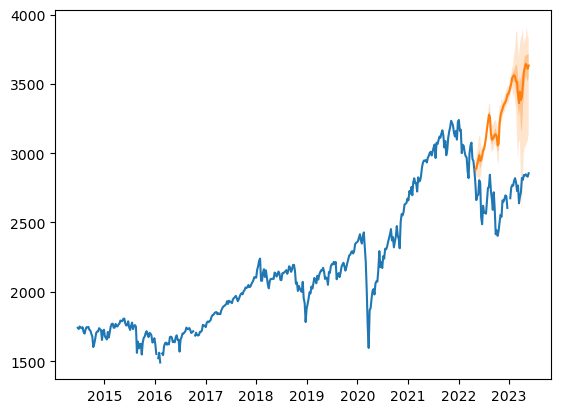

In [21]:
for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()

In [22]:
experiment_config = Forecast_Experiment(
    model = 'torch_deepar',
    version = version,
    target = target_col,
    past_rts_col = str(past_rts_col),
    epochs = max_epochs,
    prediction_length = prediction_length,
    num_layers = num_layers,
    hidden_size = hidden_size,
    context_length = context_length,
    weight_decay = weight_decay,
    lr = lr,
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

# NLP

## Experiments

In [2]:
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [3]:
Base = declarative_base()

class Experiment(Base):
    __tablename__ = 'lda_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model_path', String(100))
    dataset = Column('dataset_path', String(100))
    num_topics = Column('num_topics', Integer)
    epochs = Column('passes', Integer)


In [4]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///config/experiment_config.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Query Experiments

In [5]:
q1 = select(Experiment)
q1_result = session.execute(q1) 
for s in q1_result.scalars():
    print(f"{s.model}")

lda_model_topics_5_passes_10
lda_model_topics_10_passes_10
lda_model_topics_50_passes_10
lda_model_topics_100_passes_10
lda_model_topics_500_passes_10
lda_model_topics_1000_passes_10
lda_model_topics_10_passes_20
lda_model_topics_50_passes_20
lda_model_topics_100_passes_20
lda_model_topics_500_passes_20
lda_model_topics_1000_passes_20
lda_model_topics_10_passes_50
lda_model_topics_50_passes_50
lda_model_topics_100_passes_50
lda_model_topics_500_passes_50
lda_model_topics_1000_passes_50
lda_model_topics_1000_passes_50_on_title_lemmatized


## [LDA Modelling](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)


In [8]:
# import lda experiment method
from src.lda_script import run_lda_experiment

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Create Single Experiment

In [5]:
num_topics = 1000
num_passes = 50
dataset_name = 'cnbc_news_dataset_processed'
data_input_path = f'../data_engineering/nlp_data/{dataset_name}.csv'
data_output_path = './output_data/'
# input_column='short_description_lemmatized'
input_column='title_lemmatized'

In [6]:

# Start Experiment
run_lda_experiment(
    num_topics=num_topics,
    num_passes=num_passes,
    data_input_path=data_input_path,
    data_output_path=data_output_path,
    dataset_name=dataset_name,
    input_column=input_column
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/gensim/models/ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [11]:
model_name = f'lda_model_topics_{num_topics}_passes_{num_passes}_on_{input_column}'
experiment_config = Experiment(
    model = model_name, 
    dataset = dataset_name, 
    num_topics=num_topics, 
    epochs=num_passes
)
session.add(experiment_config)
session.commit()

### Create Set of Experiments

In [6]:
# num_topics = 1000
# num_passes = 50
dataset_name = 'cnbc_news_dataset_processed'
data_input_path = f'../data_engineering/nlp_data/{dataset_name}.csv'
data_output_path = './output_data/'
# input_column='short_description_lemmatized'
input_column='title_lemmatized'

In [9]:
for num_t in [5,10,50,100,500,1000]:
    for num_p in [5,10,50,100,500,1000]:
        # Start Experiment
        run_lda_experiment(
            num_topics=num_t,
            num_passes=num_p,
            data_input_path=data_input_path,
            data_output_path=data_output_path,
            dataset_name=dataset_name,
            input_column=input_column
        )   
        # Save model and config
        model_name = f'lda_model_topics_{num_t}_passes_{num_p}_on_{input_column}'
        experiment_config = Experiment(
            model = model_name, 
            dataset = dataset_name, 
            num_topics=num_t, 
            epochs=num_p
        )
        session.add(experiment_config)
        session.commit()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


NameError: name 'num_topics' is not defined